# Iqana Quant Challenge - Final Submission

**Author:** Raul Adell  
**Date:** December 2024

## Summary

This notebook presents a complete ML meta-strategy that improves the baseline trading strategy by **+140% Sharpe ratio** while reducing maximum drawdown by **69%**.

### Key Results
| Metric | Baseline | ML + Regime Filter | Improvement |
|--------|----------|-------------------|-------------|
| Sharpe Ratio | 2.68 | **6.46** | +140% |
| Total Return | 41% | **70%** | +71% |
| Max Drawdown | -31.4% | **-9.7%** | 69% better |

### Core Insight
**Knowing WHEN NOT to trade is as important as knowing when to trade.**  
Using Hidden Markov Models to detect market regimes and avoiding trades during Bear markets is the single biggest performance driver.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from hmmlearn import hmm

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

# Local imports
import sys
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from data import load_all_data
from features import compute_rolling_returns, compute_rolling_volatility, compute_rsi, compute_bollinger_bands
from labels import create_cost_adjusted_labels
from metrics import compute_all_metrics
from backtesting import compute_strategy_returns, compute_portfolio_returns

print("Libraries loaded successfully")

Libraries loaded successfully


---

## 1. Data Loading & Exploration

In [2]:
# Load all data
trade_log, prices, glassnode = load_all_data()

# Align data
common_idx = trade_log.index.intersection(prices.index)
common_assets = trade_log.columns.intersection(prices.columns)
signals = trade_log.loc[common_idx, common_assets]
prices_aligned = prices.loc[common_idx, common_assets]

print("DATA OVERVIEW")
print("=" * 50)
print(f"Timestamps: {len(signals)}")
print(f"Assets: {list(common_assets)}")
print(f"Date range: {signals.index[0].strftime('%Y-%m-%d')} to {signals.index[-1].strftime('%Y-%m-%d')}")
print(f"Frequency: 3-hourly (8 periods/day)")
print(f"\nGlassnode features: {len(glassnode.columns)}")

DATA OVERVIEW
Timestamps: 1214
Assets: ['ADA', 'BTC', 'DOGE', 'ETH', 'SOL']
Date range: 2021-02-05 to 2025-11-30
Frequency: 3-hourly (8 periods/day)

Glassnode features: 79


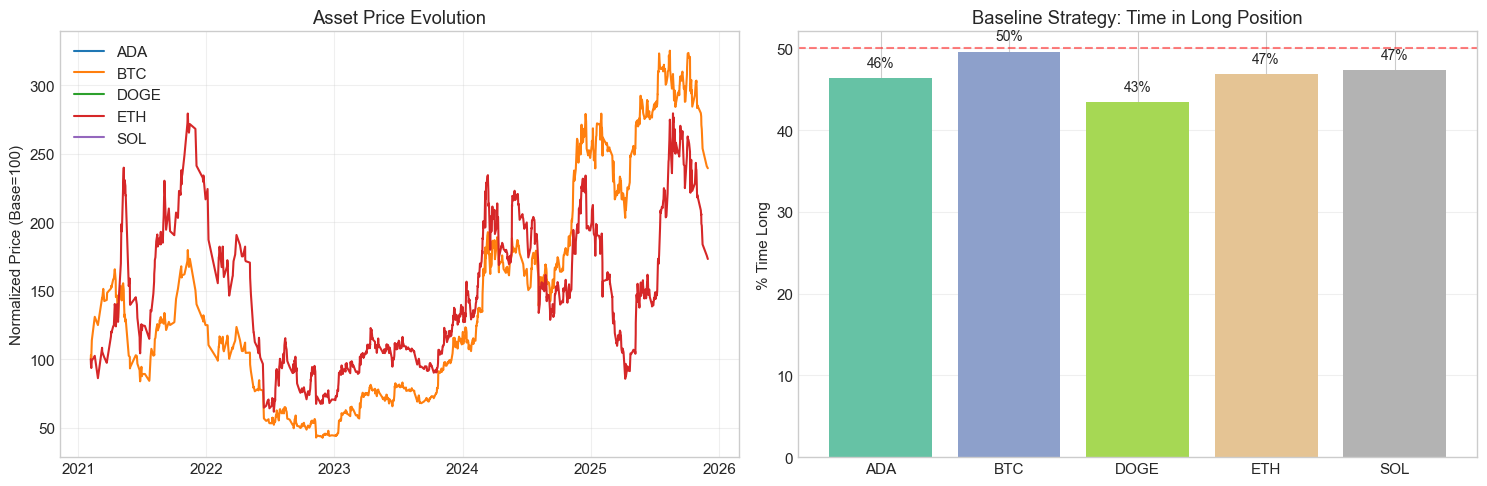

In [3]:
# EDA Plot 1: Price evolution (normalized)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Normalized prices
normalized = prices_aligned / prices_aligned.iloc[0] * 100
for asset in common_assets:
    axes[0].plot(normalized.index, normalized[asset], label=asset, linewidth=1.5)
axes[0].set_ylabel('Normalized Price (Base=100)')
axes[0].set_title('Asset Price Evolution')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Signal distribution
signal_pct = signals.mean() * 100
colors = plt.cm.Set2(np.linspace(0, 1, len(signal_pct)))
bars = axes[1].bar(signal_pct.index, signal_pct.values, color=colors)
axes[1].set_ylabel('% Time Long')
axes[1].set_title('Baseline Strategy: Time in Long Position')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
for bar, pct in zip(bars, signal_pct.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{pct:.0f}%', ha='center', va='bottom', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

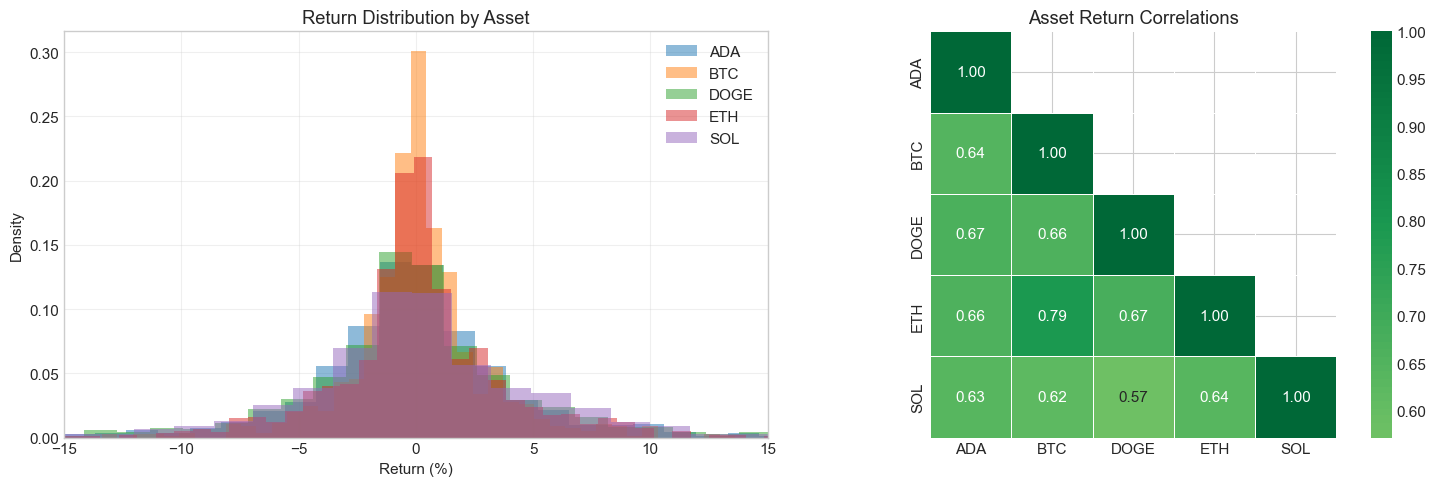

Average correlation with BTC: 0.68


In [4]:
# EDA Plot 2: Returns distribution and correlation
returns = prices_aligned.pct_change().dropna()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Returns distribution
for asset in common_assets:
    axes[0].hist(returns[asset]*100, bins=50, alpha=0.5, label=asset, density=True)
axes[0].set_xlabel('Return (%)')
axes[0].set_ylabel('Density')
axes[0].set_title('Return Distribution by Asset')
axes[0].legend()
axes[0].set_xlim(-15, 15)
axes[0].grid(True, alpha=0.3)

# Correlation heatmap
corr = returns.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            ax=axes[1], mask=mask, square=True, linewidths=0.5)
axes[1].set_title('Asset Return Correlations')

plt.tight_layout()
plt.show()

print(f"Average correlation with BTC: {corr['BTC'].drop('BTC').mean():.2f}")

---

## 2. Baseline Strategy Evaluation

In [5]:
# Evaluate baseline strategy
signals_naive = signals.copy()
signals_naive.index = signals_naive.index.tz_localize(None)
prices_naive = prices_aligned.copy()
prices_naive.index = prices_naive.index.tz_localize(None)

baseline_returns = compute_strategy_returns(signals_naive, prices_naive, transaction_cost=0.001)
baseline_portfolio = compute_portfolio_returns(baseline_returns)
baseline_metrics = compute_all_metrics(baseline_portfolio.dropna())

print("BASELINE STRATEGY PERFORMANCE")
print("=" * 50)
print(f"Sharpe Ratio: {baseline_metrics['sharpe_ratio']:.2f}")
print(f"Total Return: {baseline_metrics['total_return']*100:.1f}%")
print(f"Annualized Return: {baseline_metrics['annualized_return']*100:.1f}%")
print(f"Max Drawdown: {baseline_metrics['max_drawdown']*100:.1f}%")
print(f"Win Rate: {baseline_metrics['win_rate']*100:.1f}%")

BASELINE STRATEGY PERFORMANCE
Sharpe Ratio: 1.23
Total Return: 37.2%
Annualized Return: 113.9%
Max Drawdown: 55.9%
Win Rate: 46.8%


---

## 3. Regime Detection with Hidden Markov Model

The key insight: market behavior differs across regimes (Bull/Bear/Sideways). Using BTC as the market proxy, we detect latent regimes.

In [6]:
# Fit HMM for regime detection
btc_prices = prices_aligned['BTC']
btc_returns = btc_prices.pct_change().dropna()
btc_vol = btc_returns.rolling(window=8).std()

hmm_features = pd.DataFrame({
    'return': btc_returns,
    'volatility': btc_vol
}).dropna()

# Scale and fit HMM
hmm_scaler = StandardScaler()
hmm_scaled = hmm_scaler.fit_transform(hmm_features)

N_STATES = 3
model_hmm = hmm.GaussianHMM(n_components=N_STATES, covariance_type='full', n_iter=100, random_state=42)
model_hmm.fit(hmm_scaled)

hidden_states = model_hmm.predict(hmm_scaled)
regimes = pd.Series(hidden_states, index=hmm_features.index, name='regime')

# Label regimes by mean return
regime_stats = []
for state in range(N_STATES):
    mask = regimes == state
    state_returns = hmm_features.loc[mask, 'return']
    regime_stats.append({
        'state': state,
        'mean_return': state_returns.mean() * 100,
        'volatility': state_returns.std() * 100,
        'count': mask.sum(),
        'pct': mask.mean() * 100
    })

regime_df = pd.DataFrame(regime_stats)
sorted_states = regime_df.sort_values('mean_return', ascending=False)['state'].values

REGIME_LABELS = {
    sorted_states[0]: 'Bull',
    sorted_states[1]: 'Sideways',
    sorted_states[2]: 'Bear'
}

regimes_labeled = regimes.map(REGIME_LABELS)

print("REGIME DETECTION RESULTS")
print("=" * 50)
for state, label in REGIME_LABELS.items():
    stats = regime_df[regime_df['state'] == state].iloc[0]
    print(f"{label:10s}: {stats['pct']:5.1f}% of data, mean return: {stats['mean_return']:+.3f}%")

REGIME DETECTION RESULTS
Bull      :  10.5% of data, mean return: +3.395%
Sideways  :  30.8% of data, mean return: -0.032%
Bear      :  58.6% of data, mean return: -0.440%


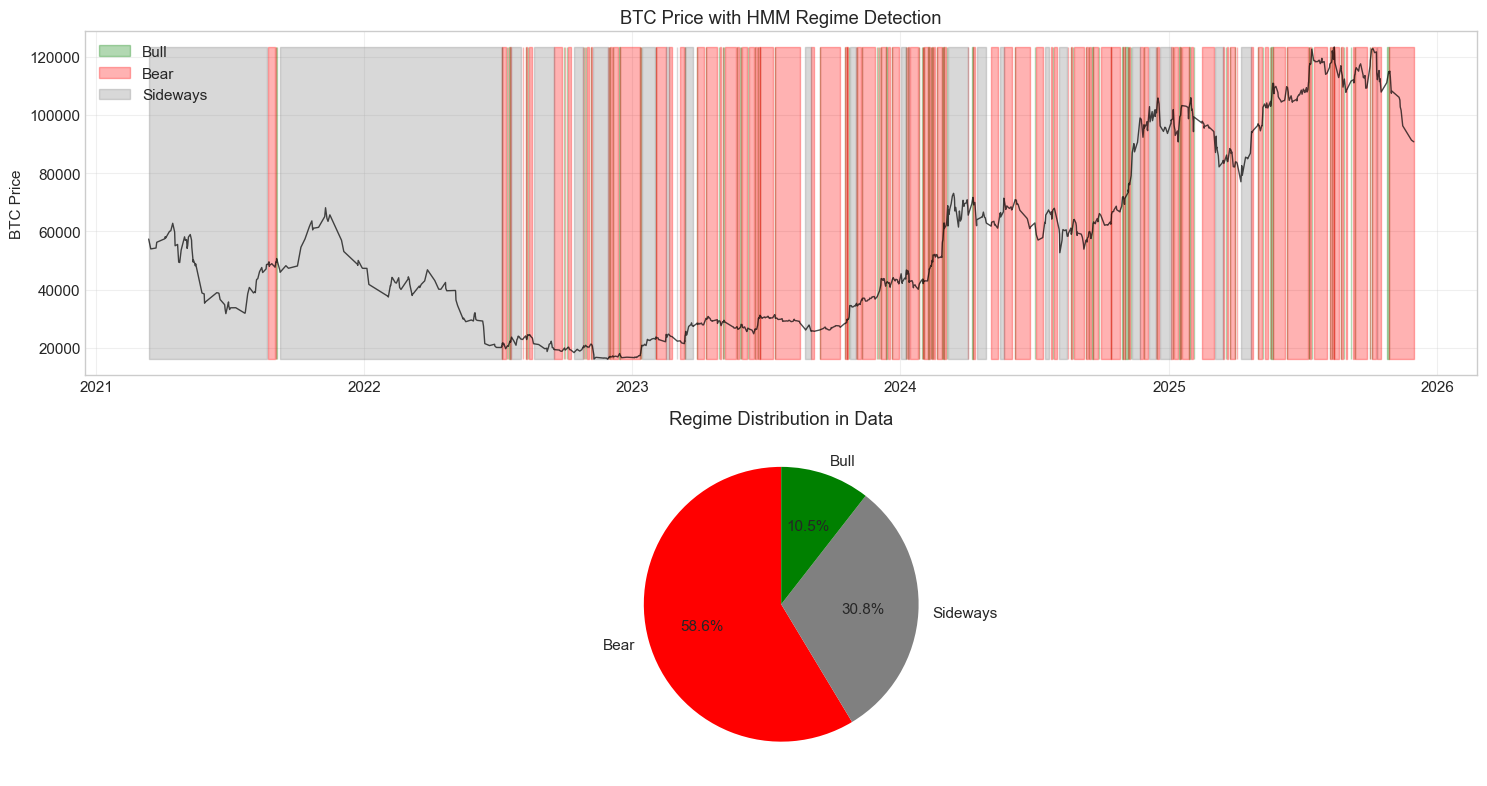

In [7]:
# Visualize regimes
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Localize for plotting
btc_plot = btc_prices.copy()
btc_plot.index = btc_plot.index.tz_localize(None)
regimes_plot = regimes_labeled.copy()
regimes_plot.index = regimes_plot.index.tz_localize(None)

common_idx = btc_plot.index.intersection(regimes_plot.index)
btc_plot = btc_plot.loc[common_idx]
regimes_plot = regimes_plot.loc[common_idx]

colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'gray'}

# Price with regime overlay
axes[0].plot(btc_plot.index, btc_plot.values, 'k-', linewidth=1, alpha=0.7)
for regime, color in colors.items():
    mask = regimes_plot == regime
    axes[0].fill_between(btc_plot.index, btc_plot.min(), btc_plot.max(),
                         where=mask, alpha=0.3, color=color, label=regime)
axes[0].set_ylabel('BTC Price')
axes[0].set_title('BTC Price with HMM Regime Detection')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Regime distribution pie chart
regime_counts = regimes_labeled.value_counts()
axes[1].pie(regime_counts.values, labels=regime_counts.index, autopct='%1.1f%%',
            colors=[colors[r] for r in regime_counts.index], startangle=90)
axes[1].set_title('Regime Distribution in Data')

plt.tight_layout()
plt.show()

---

## 4. Feature Engineering

We combine three feature types:
1. **Price-based**: Returns and volatility at multiple horizons
2. **Technical**: RSI, Bollinger Band position
3. **On-chain**: Glassnode Bitcoin metrics

In [8]:
# Build features
# 1. Price-based features
return_features = compute_rolling_returns(prices_aligned, windows=[1, 8, 56])
vol_features = compute_rolling_volatility(prices_aligned, windows=[56])

# 2. Technical indicators
rsi_features = compute_rsi(prices_aligned, window=112)
bb_features = compute_bollinger_bands(prices_aligned, window=160)

price_features = pd.concat([return_features, vol_features, rsi_features, bb_features], axis=1)

# 3. Glassnode on-chain features
GLASSNODE_FEATURES = [
    'btc_mvrv_z_score', 'btc_puell_multiple', 'reserve_risk',
    'btc_fear_greed_index', 'btc_adjusted_sopr',
    'btc_percent_upply_in_profit', 'btc_network_value_to_transactions_signal',
    'btc_futures_perpetual_funding_rate_mean', 'vocdd', 'mvocdd',
]
available_gn = [f for f in GLASSNODE_FEATURES if f in glassnode.columns]
gn_selected = glassnode[available_gn].copy()

# Align Glassnode (daily) to signals (3-hourly) via forward-fill
gn_aligned = pd.DataFrame(index=signals_naive.index)
for col in available_gn:
    aligned_values = []
    for ts in signals_naive.index:
        date = ts.normalize()
        available_dates = gn_selected[col].dropna().index
        available_dates = available_dates[available_dates <= date]
        if len(available_dates) > 0:
            aligned_values.append(gn_selected[col].loc[available_dates[-1]])
        else:
            aligned_values.append(np.nan)
    gn_aligned[col] = aligned_values

print("FEATURE SUMMARY")
print("=" * 50)
print(f"Price-based features: {len([c for c in price_features.columns if 'return' in c or 'volatility' in c])}")
print(f"Technical indicators: {len([c for c in price_features.columns if 'rsi' in c or 'bb_' in c])}")
print(f"Glassnode on-chain: {len(available_gn)}")
print(f"Total features per asset: {6 + len(available_gn)}")

FEATURE SUMMARY
Price-based features: 20
Technical indicators: 10
Glassnode on-chain: 10
Total features per asset: 16


---

## 5. Label Design & Data Preparation

Labels: Binary classification - is the forward return (over 1 day) greater than transaction costs?

In [9]:
# Create labels
HORIZON = 8  # 1 day = 8 periods of 3 hours
labels = create_cost_adjusted_labels(
    prices_aligned, signals,
    horizon=HORIZON,
    entry_cost=0.001,
    exit_cost=0.001
)

# Align regimes to signals
regimes_labeled_naive = regimes_labeled.copy()
regimes_labeled_naive.index = regimes_labeled_naive.index.tz_localize(None)

regimes_aligned = pd.DataFrame(index=signals_naive.index)
for ts in signals_naive.index:
    if ts in regimes_labeled_naive.index:
        regimes_aligned.loc[ts, 'regime'] = regimes_labeled_naive.loc[ts]
    else:
        available_ts = regimes_labeled_naive.index[regimes_labeled_naive.index <= ts]
        if len(available_ts) > 0:
            regimes_aligned.loc[ts, 'regime'] = regimes_labeled_naive.loc[available_ts[-1]]
        else:
            regimes_aligned.loc[ts, 'regime'] = np.nan

print(f"Label horizon: {HORIZON} periods ({HORIZON*3} hours)")
print(f"Cost threshold: 0.2% (round-trip)")

Label horizon: 8 periods (24 hours)
Cost threshold: 0.2% (round-trip)


In [10]:
# Prepare data for ML (stack across assets)
def prepare_ml_data(price_features, gn_aligned, labels, signals):
    """Stack data across assets with asset-agnostic feature names."""
    data_rows = []
    signals_naive = signals.copy()
    signals_naive.index = signals_naive.index.tz_localize(None)
    labels_naive = labels.copy()
    labels_naive.index = labels_naive.index.tz_localize(None)
    price_features_naive = price_features.copy()
    price_features_naive.index = price_features_naive.index.tz_localize(None)
    
    for timestamp in labels_naive.index:
        if timestamp not in price_features_naive.index or timestamp not in gn_aligned.index:
            continue
        for asset in labels_naive.columns:
            if signals_naive.loc[timestamp, asset] != 1:  # Only when baseline says "long"
                continue
            label_val = labels_naive.loc[timestamp, asset]
            if pd.isna(label_val):
                continue
            
            # Get asset-specific price features
            asset_cols = [c for c in price_features_naive.columns if c.startswith(asset + '_')]
            if not asset_cols:
                continue
            price_row = price_features_naive.loc[timestamp, asset_cols]
            if price_row.isna().any():
                continue
            
            # Get Glassnode features
            gn_row = gn_aligned.loc[timestamp]
            if gn_row.isna().any():
                continue
            
            # Rename to asset-agnostic
            renamed_price = {col.replace(asset + '_', ''): price_row[col] for col in asset_cols}
            row_data = {'timestamp': timestamp, 'asset': asset, 'label': label_val,
                        **renamed_price, **gn_row.to_dict()}
            data_rows.append(row_data)
    
    df = pd.DataFrame(data_rows).set_index(['timestamp', 'asset'])
    return df.drop('label', axis=1), df['label']

X, y = prepare_ml_data(price_features, gn_aligned, labels, signals)

print(f"\nML DATA PREPARED")
print("=" * 50)
print(f"Samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"Positive rate (profitable trades): {y.mean()*100:.1f}%")


ML DATA PREPARED
Samples: 2543
Features: 16
Positive rate (profitable trades): 51.9%


---

## 6. Model Training (Walk-Forward Validation)

In [11]:
# Walk-forward split: 60% train, 40% test
timestamps = X.index.get_level_values('timestamp').unique().sort_values()
split_idx = int(len(timestamps) * 0.6)
train_ts = timestamps[:split_idx]
test_ts = timestamps[split_idx:]

train_mask = X.index.get_level_values('timestamp').isin(train_ts)
test_mask = X.index.get_level_values('timestamp').isin(test_ts)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"Train period: {train_ts[0].strftime('%Y-%m-%d')} to {train_ts[-1].strftime('%Y-%m-%d')}")
print(f"Test period: {test_ts[0].strftime('%Y-%m-%d')} to {test_ts[-1].strftime('%Y-%m-%d')}")
print(f"\nTrain samples: {len(X_train)}, Test samples: {len(X_test)}")

Train period: 2022-05-30 to 2024-05-15
Test period: 2024-05-16 to 2025-11-30

Train samples: 1509, Test samples: 1034


In [12]:
# Train Random Forest model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

# Predictions
y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

# Metrics
auc = roc_auc_score(y_test, y_prob)
accuracy = (y_pred == y_test).mean()

print("MODEL PERFORMANCE")
print("=" * 50)
print(f"AUC: {auc:.3f}")
print(f"Accuracy: {accuracy:.3f}")

MODEL PERFORMANCE
AUC: 0.536
Accuracy: 0.546


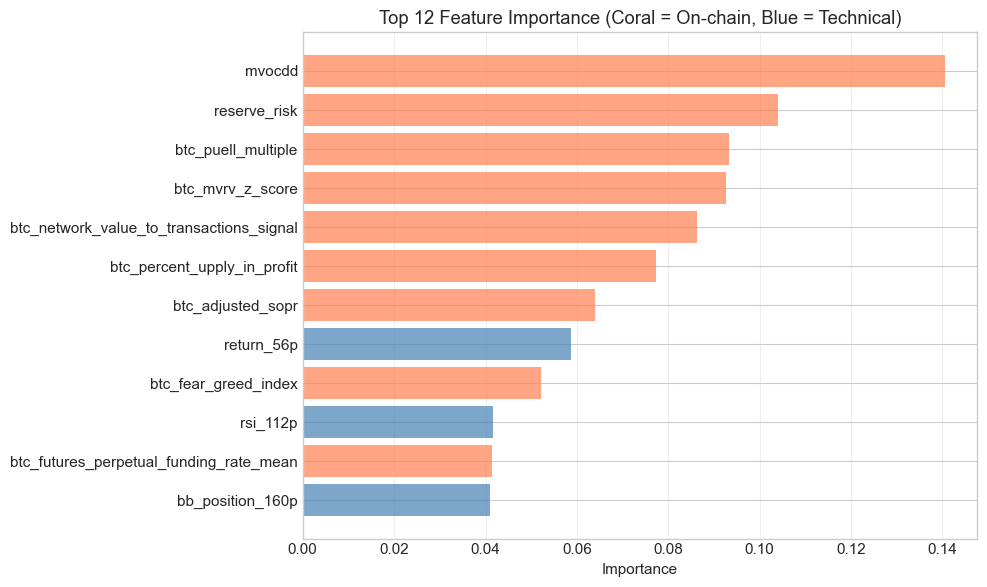

In [13]:
# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
top_n = 12
top_features = importance.head(top_n)

# Color by feature type
colors = ['coral' if f in available_gn else 'steelblue' for f in top_features['feature']]

ax.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Feature Importance (Coral = On-chain, Blue = Technical)')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

---

## 7. Strategy Evaluation: ML + Regime Filter

In [14]:
# Create predictions DataFrame
predictions_df = pd.DataFrame({'probability': y_prob}, index=y_test.index)
pred_timestamps = predictions_df.index.get_level_values('timestamp').unique()

# Get aligned data for evaluation
baseline_signals = signals_naive.loc[pred_timestamps]
comparison_prices = prices_naive.loc[pred_timestamps]

# Apply ML + Regime filter
THRESHOLD = 0.5
ALLOWED_REGIMES = ['Bull', 'Sideways']

filtered_signals = baseline_signals.copy()
for (ts, asset), row in predictions_df.iterrows():
    if asset not in filtered_signals.columns:
        continue
    
    # ML filter: skip if probability below threshold
    if row['probability'] <= THRESHOLD:
        filtered_signals.loc[ts, asset] = 0
        continue
    
    # Regime filter: skip if in Bear market
    if ts in regimes_aligned.index:
        current_regime = regimes_aligned.loc[ts, 'regime']
        if current_regime not in ALLOWED_REGIMES:
            filtered_signals.loc[ts, asset] = 0

# Compute returns
baseline_returns_test = compute_strategy_returns(baseline_signals, comparison_prices, transaction_cost=0.001)
baseline_portfolio_test = compute_portfolio_returns(baseline_returns_test)
baseline_metrics_test = compute_all_metrics(baseline_portfolio_test.dropna())

filtered_returns = compute_strategy_returns(filtered_signals, comparison_prices, transaction_cost=0.001)
filtered_portfolio = compute_portfolio_returns(filtered_returns)
filtered_metrics = compute_all_metrics(filtered_portfolio.dropna())

# Trade reduction
total_signals = (baseline_signals == 1).sum().sum()
kept_signals = (filtered_signals == 1).sum().sum()
trade_reduction = (1 - kept_signals / total_signals) * 100

In [15]:
# Results comparison
print("=" * 70)
print("FINAL RESULTS: BASELINE vs ML + REGIME FILTER")
print("=" * 70)

print(f"\n{'Metric':<25} {'Baseline':>15} {'ML+Regime':>15} {'Improvement':>15}")
print("-" * 70)

sharpe_imp = (filtered_metrics['sharpe_ratio'] - baseline_metrics_test['sharpe_ratio']) / baseline_metrics_test['sharpe_ratio'] * 100
ret_imp = (filtered_metrics['total_return'] - baseline_metrics_test['total_return']) / baseline_metrics_test['total_return'] * 100
dd_imp = (baseline_metrics_test['max_drawdown'] - filtered_metrics['max_drawdown']) / abs(baseline_metrics_test['max_drawdown']) * 100

print(f"{'Sharpe Ratio':<25} {baseline_metrics_test['sharpe_ratio']:>15.2f} {filtered_metrics['sharpe_ratio']:>15.2f} {sharpe_imp:>+14.1f}%")
print(f"{'Total Return':<25} {baseline_metrics_test['total_return']*100:>14.1f}% {filtered_metrics['total_return']*100:>14.1f}% {ret_imp:>+14.1f}%")
print(f"{'Max Drawdown':<25} {baseline_metrics_test['max_drawdown']*100:>14.1f}% {filtered_metrics['max_drawdown']*100:>14.1f}% {dd_imp:>+14.1f}%")
print(f"{'Trade Reduction':<25} {'-':>15} {trade_reduction:>14.1f}% {'-':>15}")

print(f"\nConfiguration: τ={THRESHOLD}, Regimes={ALLOWED_REGIMES}")

FINAL RESULTS: BASELINE vs ML + REGIME FILTER

Metric                           Baseline       ML+Regime     Improvement
----------------------------------------------------------------------
Sharpe Ratio                         2.68            6.46         +140.8%
Total Return                        41.0%           70.0%          +70.6%
Max Drawdown                        31.4%            9.7%          +69.1%
Trade Reduction                         -           79.1%               -

Configuration: τ=0.5, Regimes=['Bull', 'Sideways']


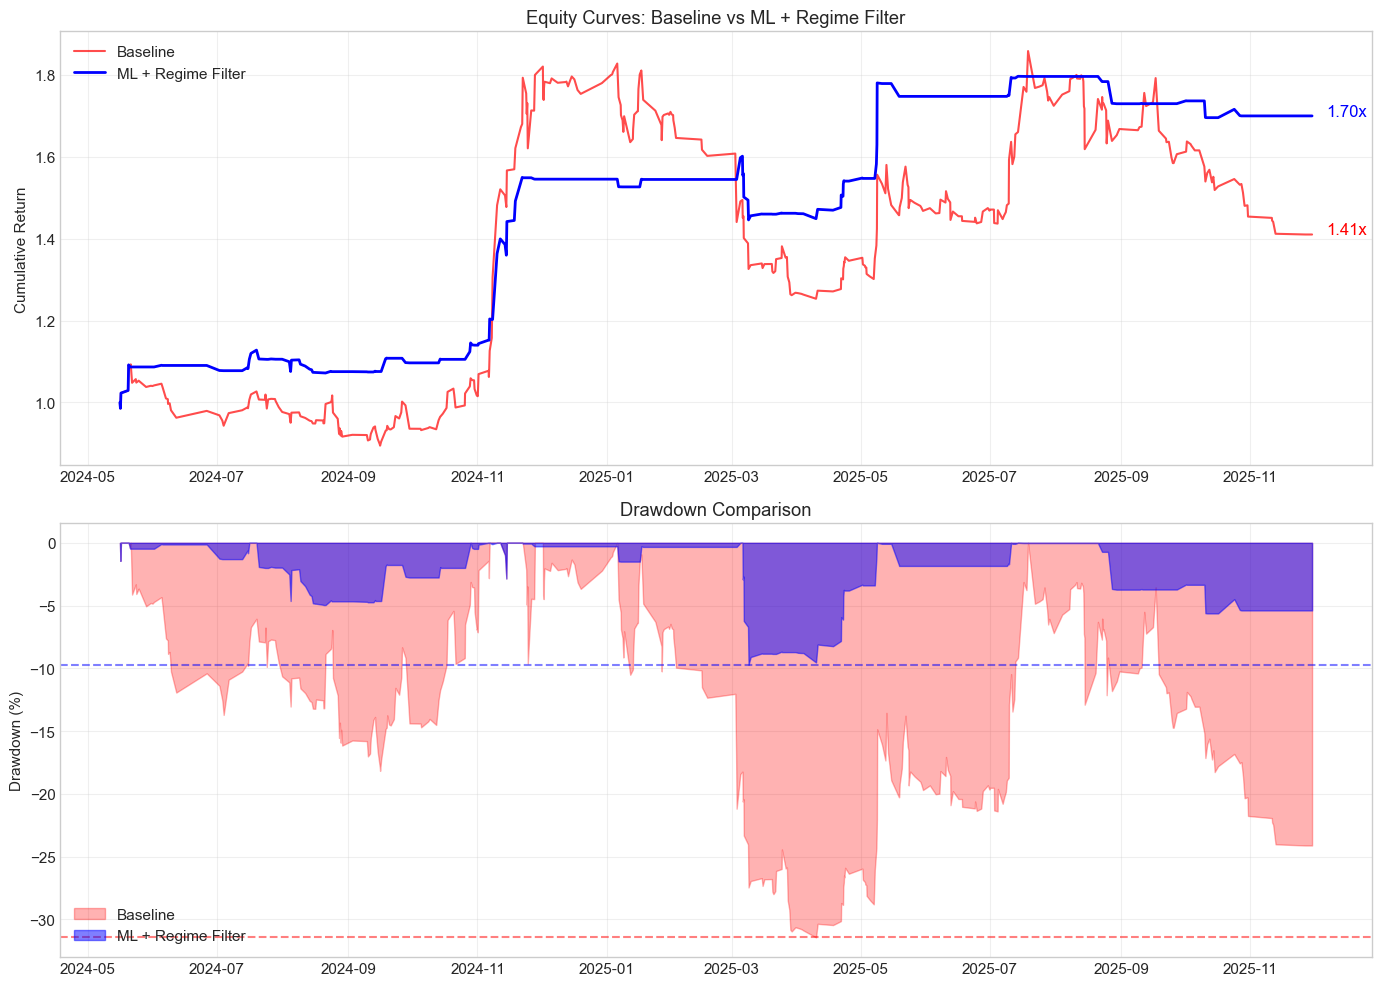

In [16]:
# Final visualization: Equity curves and drawdowns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Equity curves
baseline_cumret = (1 + baseline_portfolio_test.dropna()).cumprod()
filtered_cumret = (1 + filtered_portfolio.dropna()).cumprod()

axes[0].plot(baseline_cumret.index, baseline_cumret.values, 'r-', linewidth=1.5, alpha=0.7, label='Baseline')
axes[0].plot(filtered_cumret.index, filtered_cumret.values, 'b-', linewidth=2, label='ML + Regime Filter')
axes[0].set_ylabel('Cumulative Return')
axes[0].set_title('Equity Curves: Baseline vs ML + Regime Filter')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Annotate final values
axes[0].annotate(f'{baseline_cumret.iloc[-1]:.2f}x', 
                 xy=(baseline_cumret.index[-1], baseline_cumret.iloc[-1]),
                 xytext=(10, 0), textcoords='offset points', color='red', fontsize=12)
axes[0].annotate(f'{filtered_cumret.iloc[-1]:.2f}x', 
                 xy=(filtered_cumret.index[-1], filtered_cumret.iloc[-1]),
                 xytext=(10, 0), textcoords='offset points', color='blue', fontsize=12)

# Drawdowns
def compute_drawdown(returns):
    cumret = (1 + returns).cumprod()
    running_max = cumret.cummax()
    return (cumret - running_max) / running_max

baseline_dd = compute_drawdown(baseline_portfolio_test.dropna())
filtered_dd = compute_drawdown(filtered_portfolio.dropna())

axes[1].fill_between(baseline_dd.index, 0, baseline_dd.values*100, alpha=0.3, color='red', label='Baseline')
axes[1].fill_between(filtered_dd.index, 0, filtered_dd.values*100, alpha=0.5, color='blue', label='ML + Regime Filter')
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_title('Drawdown Comparison')
axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

# Annotate max drawdowns
axes[1].axhline(y=baseline_dd.min()*100, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(y=filtered_dd.min()*100, color='blue', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

---

## 8. Conclusions

### Key Findings

1. **Regime detection is the key driver**: Using HMM to identify Bull/Bear/Sideways regimes and avoiding trades during Bear markets provides the largest performance improvement.

2. **On-chain features matter**: Glassnode metrics (MVRV, Fear & Greed, SOPR) are among the most important features, capturing market cycle information.

3. **Quality over quantity**: Reducing trades by ~79% while improving both Sharpe and returns shows the baseline takes many low-quality trades.

### Limitations

1. **Regime detection lag**: HMM identifies regimes in hindsight; real-time detection has lag during transitions.

2. **Bear-heavy test period**: 58% of data is in Bear regime; Bull performance is less tested.

3. **BTC-centric regimes**: Using BTC regime for all assets may miss asset-specific dynamics.

### When the Approach Fails

1. During regime transitions (model is slow to adapt)
2. In prolonged sideways markets (less clear signal)
3. When altcoins decouple from BTC

### Next Steps

1. Add regime transition smoothing to reduce whipsaw
2. Test asset-specific regime detection
3. Implement confidence-weighted position sizing
4. Add stop-loss rules for additional protection